In [14]:
import os
import re
import cv2
import ast
import random
import pandas as pd
import numpy as np

from PIL import Image
import albumentations as A
from collections import namedtuple
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path


In [15]:
BASE_DIR = Path('data')
TRAIN_DIR = BASE_DIR/'train_images'
AUG_DIR = BASE_DIR/'train_images_augument'
IMAGE_EXTENSION = '.jpeg'
IMAGE_EXTENSION_LEN = len(IMAGE_EXTENSION)

In [16]:
def load_data():
    train_df = pd.read_csv(BASE_DIR/'train.csv')
    print('DataFrame size: ',train_df.shape)
    return train_df

In [17]:
train_df = load_data()

DataFrame size:  (8025, 8)


In [18]:
train_df

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,92715872-3287-4bff-aa61-7047973e5c02.jpeg,2448,3264,1301,1546,1641,2096,albopictus
1,b0f7cc74-2272-4756-a387-38bcaf6965c8.jpeg,3024,4032,900,1897,1950,2990,albopictus
2,82df4b68-0f45-4afe-9215-48488bf3720e.jpeg,768,1024,220,58,659,808,albopictus
3,331ad30a-7564-4478-b863-7bc760adf5a1.jpeg,3456,4608,1169,2364,1586,2826,albopictus
4,1a46dbfb-104e-466b-88d7-98958d7b1fe9.jpeg,1024,1365,129,231,697,1007,culex
...,...,...,...,...,...,...,...,...
8020,ca1468e3-1337-48b3-b378-135758317454.jpeg,4160,2080,2055,704,2494,998,albopictus
8021,c2e77768-61ba-4e27-907d-fe3198e8f5ce.jpeg,3024,4032,1073,875,1830,1503,culiseta
8022,d7521d94-92f7-40a1-9cd5-74a0b67ca98b.jpeg,1024,1365,341,485,761,1123,albopictus
8023,03098cc0-ee82-4fa0-b045-579951b7855c.jpeg,2128,4608,869,1235,2128,2631,culex


In [29]:

def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    for bbox in bboxes:
        bbox = np.array(bbox).astype(int)
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

def read_img(img_id):
    img_path = TRAIN_DIR/f'{img_id}'
    print(img_path)
    img = cv2.imread(str(img_path))
    return img

def save_img(image, image_filename):
    img_path = AUG_DIR/f'{image_filename}'
    print(img_path)
    # image.save(img_path)
    cv2.imwrite(img_path, image)

def read_bboxes(img_id):
    return train_df.loc[train_df.img_fName == img_id][['bbx_xtl', 'bbx_ytl', 'bbx_xbr', 'bbx_ybr']].values

def plot_img(img_id, bbox=False):
    img    = read_img(img_id)
    if bbox:
        bboxes = read_bboxes(img_id)
        img    = draw_rect(img, bboxes)
    plt.imshow(img)
    
def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=3, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        myaxes[i // ncols][i % ncols].grid(False)
        myaxes[i // ncols][i % ncols].set_xticks([])
        myaxes[i // ncols][i % ncols].set_yticks([])

    plt.show()

In [7]:
img_id = "0a1dba18-4767-4526-a3b3-70ba7d0560fb.jpeg"

data\train_images\0a1dba18-4767-4526-a3b3-70ba7d0560fb.jpeg


c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


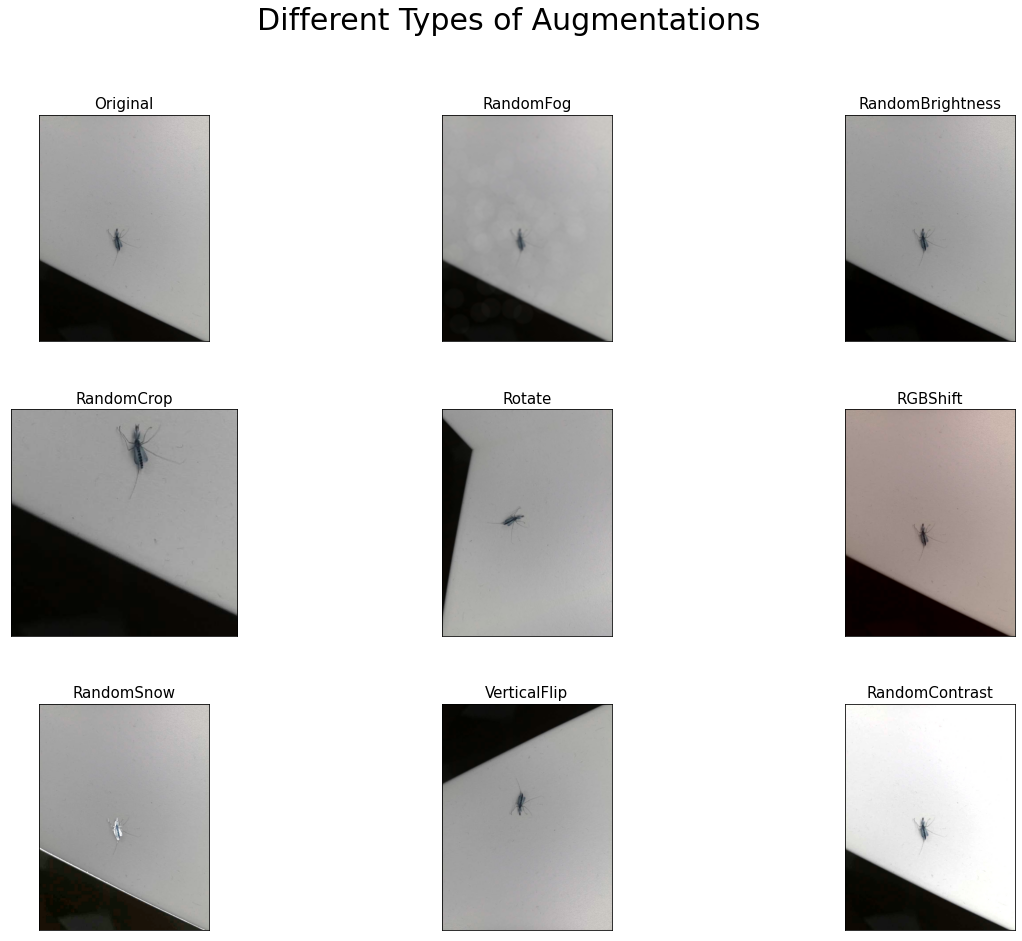

In [20]:
chosen_img = read_img(img_id)

albumentation_list = [A.RandomFog(p=1), 
                      A.RandomBrightness(p=1), 
                      A.RandomCrop(p=1,height = 512, width = 512), 
                      A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), 
                      A.RandomSnow(p=1), 
                      A.VerticalFlip(p=1), 
                      A.RandomContrast(limit = 0.5,p = 1)]

titles_list = ["Original", 
               "RandomFog",
               "RandomBrightness", 
               "RandomCrop",
               "Rotate", 
               "RGBShift", 
               "RandomSnow", 
               "VerticalFlip", 
               "RandomContrast"]

img_matrix_list = [chosen_img]
for aug_type in albumentation_list:
    img = aug_type(image = chosen_img)['image']
    img_matrix_list.append(img)

plot_multiple_img(img_matrix_list, 
                  titles_list, 
                  ncols = 3, 
                  main_title="Different Types of Augmentations")

data\train_images\0a1dba18-4767-4526-a3b3-70ba7d0560fb.jpeg
[[299 502 452 683]]


c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(299.0, 502.0, 452.0, 683.0)
(1024, 768, 3)
(299.0, 502.0, 452.0, 683.0)
(1024, 768, 3)
(227.0, 299.0, 380.0, 480.0)
(512, 512, 3)
(303.28798033750695, 473.06458960655056, 520.3811507566455, 702.9582634229268)
(1024, 768, 3)
(299.0, 502.0, 452.0, 683.0)
(1024, 768, 3)
(299.0, 502.0, 452.0, 683.0)
(1024, 768, 3)
(299.0, 341.0, 452.0, 522.0)
(1024, 768, 3)
(299.0, 502.0, 452.0, 683.0)
(1024, 768, 3)


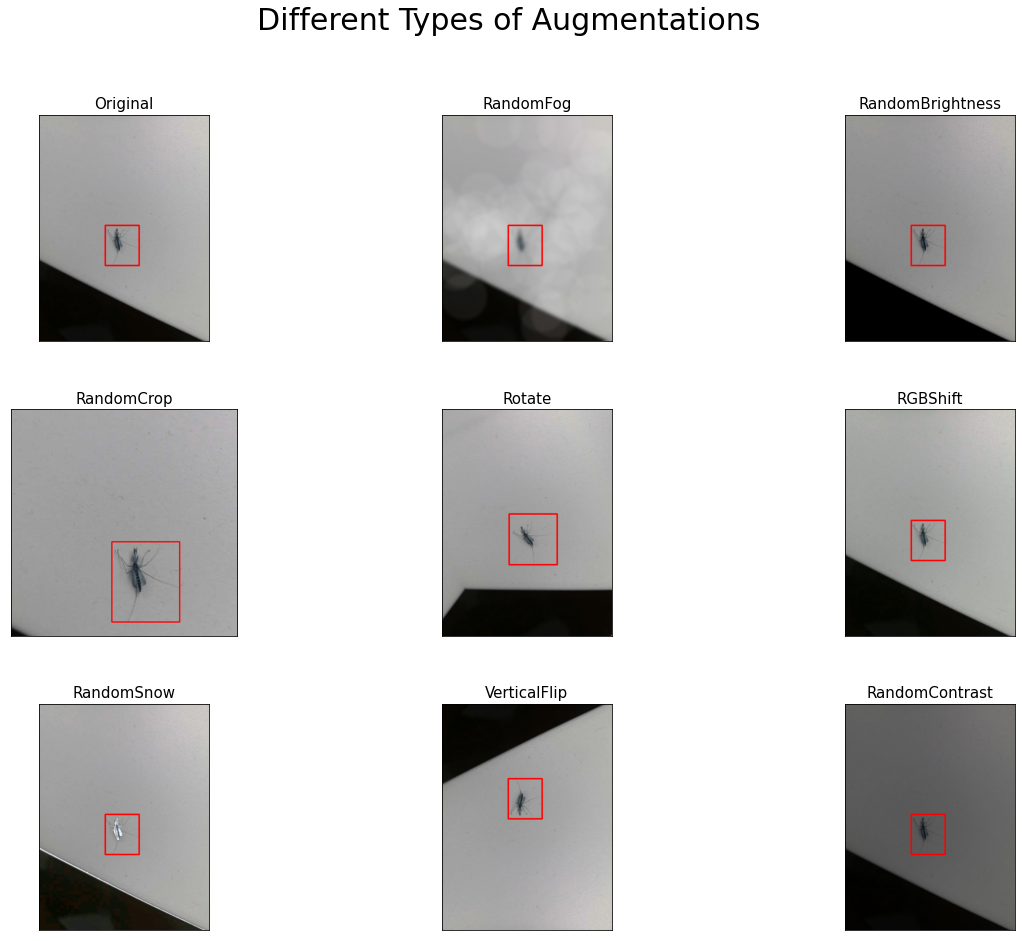

In [21]:
chosen_img = read_img(img_id)
bboxes = read_bboxes(img_id)
print(bboxes)
bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}

albumentation_list = [A.Compose([A.RandomFog(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomBrightness(p=1)], bbox_params=bbox_params),
                      A.Compose([A.RandomCrop(p=1, height=512, width=512)], bbox_params=bbox_params), 
                      A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
                      A.Compose([A.RGBShift(p=1)], bbox_params=bbox_params), 
                      A.Compose([A.RandomSnow(p=1)], bbox_params=bbox_params),
                      A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params), 
                      A.Compose([A.RandomContrast(limit=0.5, p = 1)], bbox_params=bbox_params)
                     ]

titles_list = ["Original", 
               "RandomFog",
               "RandomBrightness", 
               "RandomCrop",
               "Rotate", 
               "RGBShift", 
               "RandomSnow", 
               "VerticalFlip", 
               "RandomContrast"]

img_matrix_list = [draw_rect(chosen_img, bboxes)]

for aug_type in albumentation_list:
    anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)))
    # print(anno)
    img  = draw_rect(anno['image'], anno['bboxes'])
    print(anno['bboxes'][0])
    print(anno['image'].shape)
    img_matrix_list.append(img)

    # break


plot_multiple_img(img_matrix_list, 
                  titles_list, 
                  ncols = 3, 
                  main_title="Different Types of Augmentations")

In [24]:
titles_list = ["Original", 
               "RandomFog",
               "RandomBrightness", 
               "RandomCrop",
               "Rotate", 
               "RGBShift", 
               "RandomSnow", 
               "VerticalFlip", 
               "RandomContrast"]

def augument_data(img_name, img_w, img_h, bbx_xtl, bbx_ytl, bbx_xbr, bbx_ybr):
    chosen_img = read_img(img_name)
    bboxes = [[bbx_xtl, bbx_ytl, bbx_xbr, bbx_ybr]]
    bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}

    albumentation_list = [A.Compose([A.RandomFog(p=1)], bbox_params=bbox_params),
                        A.Compose([A.RandomBrightness(p=1)], bbox_params=bbox_params),
                        A.Compose([A.RandomCrop(p=1, height=512, width=512)], bbox_params=bbox_params), 
                        A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
                        A.Compose([A.RGBShift(p=1)], bbox_params=bbox_params), 
                        A.Compose([A.RandomSnow(p=1)], bbox_params=bbox_params),
                        A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params), 
                        A.Compose([A.RandomContrast(limit=0.5, p = 1)], bbox_params=bbox_params)
                        ]
    
    aug_data.append([img_name, img_w, img_h, bbx_xtl, bbx_ytl, bbx_xbr, bbx_ybr])

    for i, aug_type in enumerate(albumentation_list):
        anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)))
        # print(anno)
        img  = draw_rect(anno['image'], anno['bboxes'])
        bbx_xtl_, bbx_ytl_, bbx_xbr_, bbx_ybr_ = anno['bboxes'][0]
        img_h_, img_w_ = int(anno['image'].shape[0]), int(anno['image'].shape[1])
        new_img_name = img_name[0:len(img_name) - IMAGE_EXTENSION_LEN]+"_"+titles_list[i].lower()+IMAGE_EXTENSION
        save_img(anno['image'], new_img_name)
        aug_data.append([new_img_name, img_w_, img_h_, bbx_xtl_, bbx_ytl_, bbx_xbr_, bbx_ybr_])


    


In [30]:
aug_data = []
for i,row in train_df.head(10).iterrows():
    img_name = row['img_fName']
    img_w = row['img_w']
    img_h = row['img_h']
    bbx_xtl = row['bbx_xtl']
    bbx_ytl = row['bbx_ytl']
    bbx_xbr = row['bbx_xbr']
    bbx_ybr = row['bbx_ybr']
    augument_data(img_name, img_w, img_h, bbx_xtl, bbx_ytl, bbx_xbr, bbx_ybr)
df_aug = pd.DataFrame(aug_data, columns=train_df.columns)
    
    


data\train_images\92715872-3287-4bff-aa61-7047973e5c02.jpeg


c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


data\train_images_augument\92715872-3287-4bff-aa61-7047973e5c02_original.jpeg


error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - Can't convert object to 'str' for 'filename'
>  - Can't convert object to 'str' for 'filename'
